In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
# import data from CA, CT, TX, FL, NY, NJ 
ca = pd.read_csv('data/ca_ev_registrations_public.csv')
nj = pd.read_csv('data/nj_ev_registrations_public.csv')
ny = pd.read_csv('data/ny_ev_registrations_public.csv')
tx = pd.read_csv('data/tx_ev_registrations_public.csv')
fl = pd.read_csv('data/fl_ev_registrations_public.csv')
ct = pd.read_csv('data/ct_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
ca.info()
# 2542443 entries in CA
nj.info()
# NJ has 309872 entries
ny.info()
tx.info()
ct.info()
fl.info()
# ca['Registration Valid Date'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542443 entries, 0 to 2542442
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Vehicle ID                    object 
 1   County GEOID                  object 
 2   Registration Valid Date       object 
 3   DMV ID                        int64  
 4   DMV Snapshot                  object 
 5   Registration Expiration Date  float64
 6   State Abbreviation            object 
 7   Geography                     object 
 8   Vehicle Name                  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 174.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309872 entries, 0 to 309871
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DMV ID                        309872 non-null  int64  
 1   DMV Snapshot (Date)           309872 non-null  object 


In [4]:
# Create Data frame with years and amount of registered vehicles in that year
ca_years = pd.DataFrame(ca['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

<AxesSubplot:xlabel='Year'>

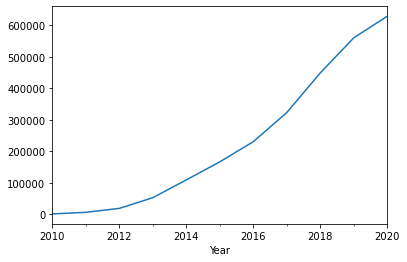

In [5]:
# As we can see, data is not stationary. 
ca_df = pd.Series(ca_years['Registered Vehicles'])
ca_df = ca_df.set_axis(pd.to_datetime(ca_years['Year']))
ca_df.plot()

In [6]:
catest = adfuller(ca_df)
display(catest)
# Pvalue - 0.41624347392997485

(-1.7289856139173432,
 0.41624347392997485,
 3,
 7,
 {'1%': -4.9386902332361515,
  '5%': -3.477582857142857,
  '10%': -2.8438679591836733},
 138.47165121551794)

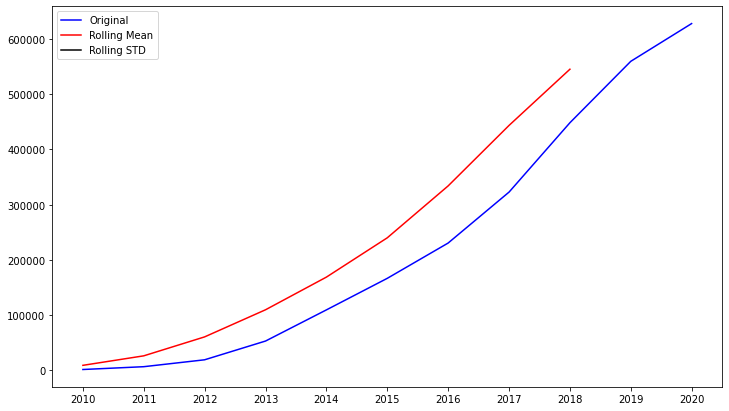

In [7]:
# Subtracting the rolling mean 
rmean = ca_df.rolling(window = 3, center = False).mean()
rstd = ca_df.rolling(window=1, center = False).std()

fig = plt.figure(figsize=(12,7))
ca_orig = plt.plot(ca_df, color = 'blue', label = 'Original')
cmean = plt.plot(rmean, color = 'red', label = 'Rolling Mean')
cstd = plt.plot(rstd, color = 'black', label = 'Rolling STD')
plt.legend(loc='best')
plt.show(block=False)

In [15]:
ca_df = ca_df.astype(float)
ca_df.head()

Year
2020-01-01    628473.0
2019-01-01    559969.0
2018-01-01    448567.0
2017-01-01    322762.0
2016-01-01    230171.0
Name: Registered Vehicles, dtype: float64

In [14]:
decomposition = seasonal_decompose(np.log(ca_df))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
plt.figure(figsize(12,8))

In [ ]:
# Differencing to be stationary 
# ca_diff = ca_df.diff().dropna()
# ca_diff.plot()

In [ ]:
cadifftest = adfuller(ca_diff)
display(cadifftest)
# Pvalue -  0.9754235581948372

In [ ]:

# plot_acf(ca_diff, ax=ax, lags = 3)

#### Lets take the necessary data from each of the data frames - specifically date, and convert them into a usable format as they are currently 'objects' and need them to be in datetime format for analyses

In [ ]:
# ca_dt = pd.to_datetime(ca['Registration Valid Date'])
# ct_dt = pd.to_datetime(ct['Registration Valid Date'])
# tx_dt = pd.to_datetime(tx['Registration Valid Date'])
# fl_dt = pd.to_datetime(fl['Registration Valid Date'])
# ny_dt = pd.to_datetime(ny['Registration Valid Date'])
# nj_dt = pd.to_datetime(nj['Registration Valid Date'])

# def get_datetimes(df):
#     """
#     Takes a dataframe:
#     returns only those column names that can be converted into datetime objects 
#     as datetime objects.
#     NOTE number of returned columns may not match total number of columns in passed dataframe
#     """
    
#     return pd.to_datetime(df.columns.values[7:-5], format='%Y-%m')